# objects — detekcja obiektów / eksperymenty

> Szkielet notatnika do eksploracji detekcji innych rzeczy niż napisy.

*Uwaga:* na tym etapie nie instalujemy ciężkich bibliotek. Najpierw prototypuj i notuj wyniki.


### 0) Diagnoza środowiska

In [1]:
import sys, platform, os, importlib
print("PY:", sys.executable, platform.python_version())
mods = ["cv2", "google.cloud.vision", "PIL", "numpy"]
for m in mods:
    try:
        importlib.import_module(m)
        print("[OK]", m)
    except Exception as e:
        print("[FAIL]", m, "->", repr(e))


PY: /Users/olga/MetaLogic/.venv/bin/python 3.13.7
[OK] cv2
[OK] google.cloud.vision
[OK] PIL
[OK] numpy


### 1) Ustawienia ścieżek i katalogów

In [2]:
from pathlib import Path
IMG_DIR = Path.home() / "MetaLogic" / "inputs"
OUT_DIR = Path.home() / "MetaLogic" / "outputs" / "objects"
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("IMG_DIR:", IMG_DIR)
print("OUT_DIR:", OUT_DIR)


IMG_DIR: /Users/olga/MetaLogic/inputs
OUT_DIR: /Users/olga/MetaLogic/outputs/objects


### 2) Wybór obrazu (dropdown)

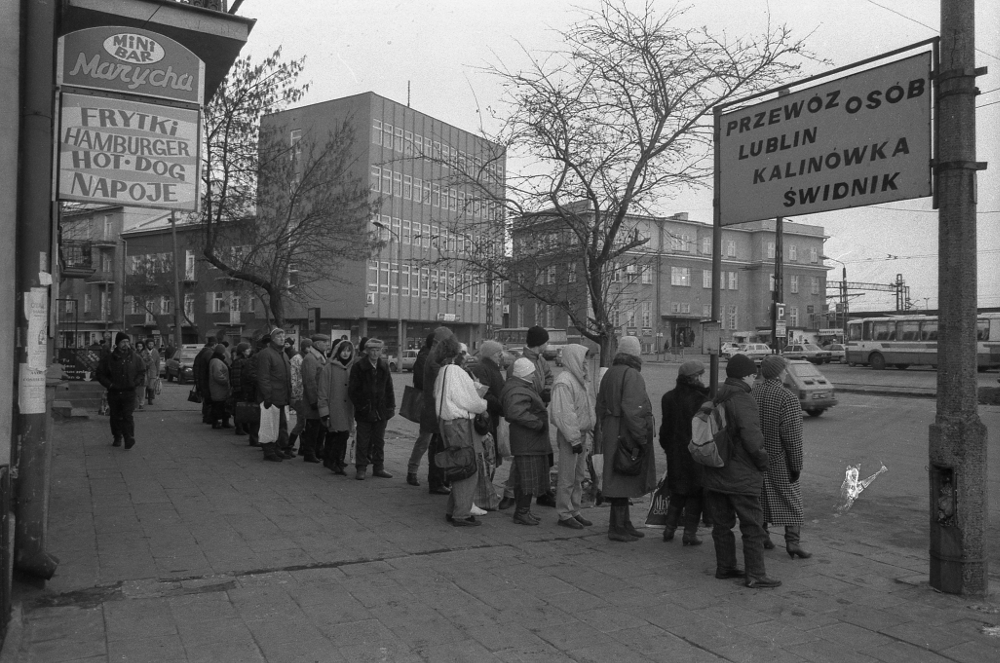

In [ ]:
from ipywidgets import Dropdown, Button, HBox, VBox, HTML
from IPython.display import display
from PIL import Image

EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".webp"}

def list_images():
    return sorted([p for p in IMG_DIR.iterdir() if p.is_file() and p.suffix.lower() in EXTS])

files = list_images()
status = HTML(value=f"Katalog: {IMG_DIR} • {len(files)} plików")
dd = Dropdown(options=[(p.name, str(p)) for p in files], description="Obraz:", layout={"width":"600px"})
btn_refresh = Button(description="Odśwież")
btn_use = Button(description="Użyj", disabled=(len(files)==0))

IMG_PATH = None  # global

def on_refresh(_):
    global files
    files = list_images()
    dd.options = [(p.name, str(p)) for p in files]
    btn_use.disabled = (len(files)==0)
    status.value = f"Katalog: {IMG_DIR} • {len(files)} plików"

def on_use(_):
    global IMG_PATH
    if not dd.value:
        status.value = "Brak wyboru."
        return
    from pathlib import Path
    IMG_PATH = Path(dd.value)
    status.value = f"✅ Wybrano: {IMG_PATH}"
    display(Image.open(IMG_PATH))

btn_refresh.on_click(on_refresh)
btn_use.on_click(on_use)
display(VBox([HBox([dd, btn_refresh, btn_use]), status]))


### 3) Podgląd obrazu i wymiary

Wymiary: (1000, 663)


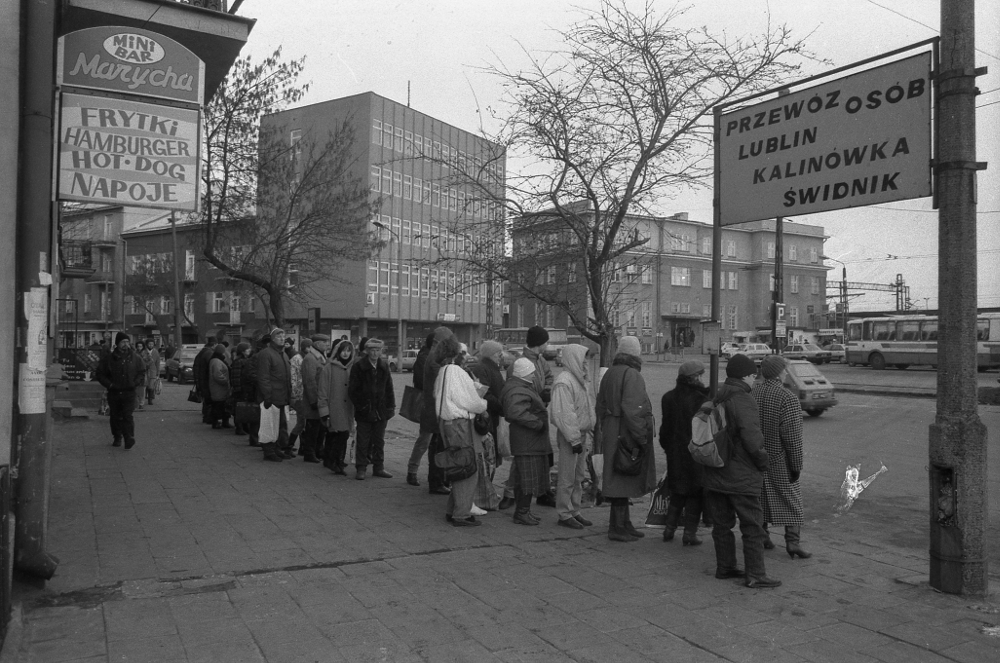

In [24]:
assert 'IMG_PATH' in globals() and IMG_PATH is not None, "Najpierw wybierz obraz w sekcji 2)"
im = Image.open(IMG_PATH).convert("RGB")
print("Wymiary:", im.size)
display(im)


### 4) Wybór detektora (szkic interfejsu)

In [25]:
# Docelowo: wybierz jedną lub wiele opcji i porównuj wyniki.
# A) Google Vision (Localized Object Annotations) — bez instalacji, ale płatne API
# B) OpenCV DNN (np. MobileNet-SSD) — lekki baseline, wymaga modelu .caffemodel / ONNX (do wgrania później)
# C) YOLOv8/YOLOv10 (Ultralytics) / RT-DETR — cięższe, do późniejszych eksperymentów

DETECTOR = "vision"   # "vision" | "opencv" | "ultralytics"
print("DETECTOR:", DETECTOR)


DETECTOR: vision


### Key

In [26]:
import os
from pathlib import Path

KEY = Path.home() / "MetaLogic" / "secrets" / "vision-key.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(KEY)
print("exists:", KEY.exists(), "→", KEY)

exists: True → /Users/olga/MetaLogic/secrets/vision-key.json


### 5) Google Vision — wykrywanie obiektów (placeholder działający)

In [27]:
from google.cloud import vision
from io import BytesIO

def vision_objects(pil_img):
    client = vision.ImageAnnotatorClient()
    buf = BytesIO(); pil_img.save(buf, format="JPEG", quality=90)
    image = vision.Image(content=buf.getvalue())
    resp = client.object_localization(image=image)
    objs = []
    for obj in resp.localized_object_annotations:
        # polygon -> bbox przybliżone
        xs = [v.x for v in obj.bounding_poly.normalized_vertices]
        ys = [v.y for v in obj.bounding_poly.normalized_vertices]
        objs.append({
            "name": obj.name,
            "score": float(obj.score),
            "bbox_norm": [min(xs), min(ys), max(xs), max(ys)],
            "vertices_norm": [[v.x, v.y] for v in obj.bounding_poly.normalized_vertices],
            "src": "vision"
        })
    return objs

if DETECTOR == "vision":
    objects = vision_objects(im)
    print(f"Wykryto obiektów: {len(objects)}")
    for o in objects[:20]:
        print(f"- {o['name']} ({o['score']:.2f}) bbox_norm={o['bbox_norm']}")
else:
    objects = []
    print("Pomiń — aktualny DETECTOR to:", DETECTOR)


Wykryto obiektów: 10
- Person (0.76) bbox_norm=[0.494140625, 0.51953125, 0.546875, 0.7890625]
- Clothing (0.76) bbox_norm=[0.49609375, 0.546875, 0.546875, 0.76171875]
- Clothing (0.75) bbox_norm=[0.54296875, 0.53515625, 0.58984375, 0.67578125]
- Person (0.74) bbox_norm=[0.345703125, 0.5078125, 0.392578125, 0.72265625]
- Person (0.74) bbox_norm=[0.65625, 0.53125, 0.70703125, 0.82421875]
- Person (0.73) bbox_norm=[0.42578125, 0.51171875, 0.4921875, 0.7890625]
- Clothing (0.72) bbox_norm=[0.74609375, 0.56640625, 0.8046875, 0.73046875]
- Clothing (0.72) bbox_norm=[0.345703125, 0.53125, 0.392578125, 0.63671875]
- Person (0.72) bbox_norm=[0.6875, 0.51953125, 0.77734375, 0.88671875]
- Building (0.72) bbox_norm=[0.25, 0.134765625, 0.5078125, 0.51171875]


### 6) Wizualizacja wykrytych obiektów (bbox/polygons)

In [28]:
# --- Vision OBJECT_LOCALIZATION na kafelkach + skalowanie ---
from google.cloud import vision
from PIL import Image, ImageEnhance
from io import BytesIO
import math, json

ROWS, COLS, OVERLAP = 3, 4, 0.30
SCALES = [1.0, 1.5]           # kilka skal dla małych obiektów
SCORE_MIN = 0.45

def _prep(img, max_side=2200, contrast=1.25, q=90) -> bytes:
    w,h = img.size
    s = min(1.0, max_side/max(w,h))
    if s < 1.0:
        img = img.resize((int(w*s), int(h*s)), Image.LANCZOS)
    img = ImageEnhance.Contrast(img.convert("L")).enhance(contrast).convert("RGB")
    buf = BytesIO(); img.save(buf, "JPEG", quality=q, optimize=True); 
    return buf.getvalue(), (img.size[0]/w, img.size[1]/h)

def _tiles(w, h, rows=ROWS, cols=COLS, overlap=OVERLAP):
    tw, th = w/cols, h/rows
    sx, sy = tw*(1-overlap), th*(1-overlap)
    for r in range(rows):
        for c in range(cols):
            x1, y1 = int(round(c*sx)), int(round(r*sy))
            x2 = int(round(x1+tw)) if c < cols-1 else w
            y2 = int(round(y1+th)) if r < rows-1 else h
            yield (r*cols+c+1), (x1,y1,x2,y2)

def vision_loc_per_tile(img_full: Image.Image):
    client = vision.ImageAnnotatorClient()
    W,H = img_full.size
    out = []
    for scale in SCALES:
        base = img_full if scale==1.0 else img_full.resize((int(W*scale), int(H*scale)), Image.LANCZOS)
        for idx, (x1,y1,x2,y2) in _tiles(*base.size):
            crop = base.crop((x1,y1,x2,y2))
            content, _ = _prep(crop, max_side=2400, contrast=1.2, q=90)
            req = vision.Image(content=content)
            resp = client.object_localization(image=req)
            for o in resp.localized_object_annotations:
                xs = [v.x for v in o.bounding_poly.normalized_vertices]
                ys = [v.y for v in o.bounding_poly.normalized_vertices]
                # bbox w cropie -> do globalnych pikseli w obrazie base
                gx1 = x1 + min(xs)* (x2-x1)
                gy1 = y1 + min(ys)* (y2-y1)
                gx2 = x1 + max(xs)* (x2-x1)
                gy2 = y1 + max(ys)* (y2-y1)
                # przeskaluj z 'base' do oryginału (jeśli scale != 1.0)
                s = scale
                out.append({
                    "name": o.name,
                    "score": float(o.score),
                    "bbox": [gx1/s, gy1/s, gx2/s, gy2/s],
                    "tile": idx, "scale": scale
                })
            resp_logo = client.logo_detection(image=req)
            for logo in resp_logo.logo_annotations:
                out.append({
                    "name": "LOGO:" + logo.description,
                    "score": float(logo.score),
                    "bbox": [x1, y1, x2, y2],  # cały kafelek, bo Vision nie daje precyzyjnych boxów logo
                    "tile": idx,
                    "scale": scale,
                    "src": "logo"
                })
    # odfiltruj niskie skory
    return [d for d in out if d["score"] >= SCORE_MIN]

img0 = Image.open(IMG_PATH).convert("RGB")
raw_objs = vision_loc_per_tile(img0)
print(f"Zebrano {len(raw_objs)} detekcji (przed NMS). Przykład:", raw_objs[:2])

Zebrano 155 detekcji (przed NMS). Przykład: [{'name': 'Building', 'score': 0.6785803437232971, 'bbox': [254.58984375, 88.91796875, 423.046875, 221.0], 'tile': 2, 'scale': 1.0}, {'name': 'Building', 'score': 0.6297973394393921, 'bbox': [350.0, 90.212890625, 505.2734375, 221.0], 'tile': 3, 'scale': 1.0}]


### 7) Komórka: NMS + wizualizacja

Po NMS: 65


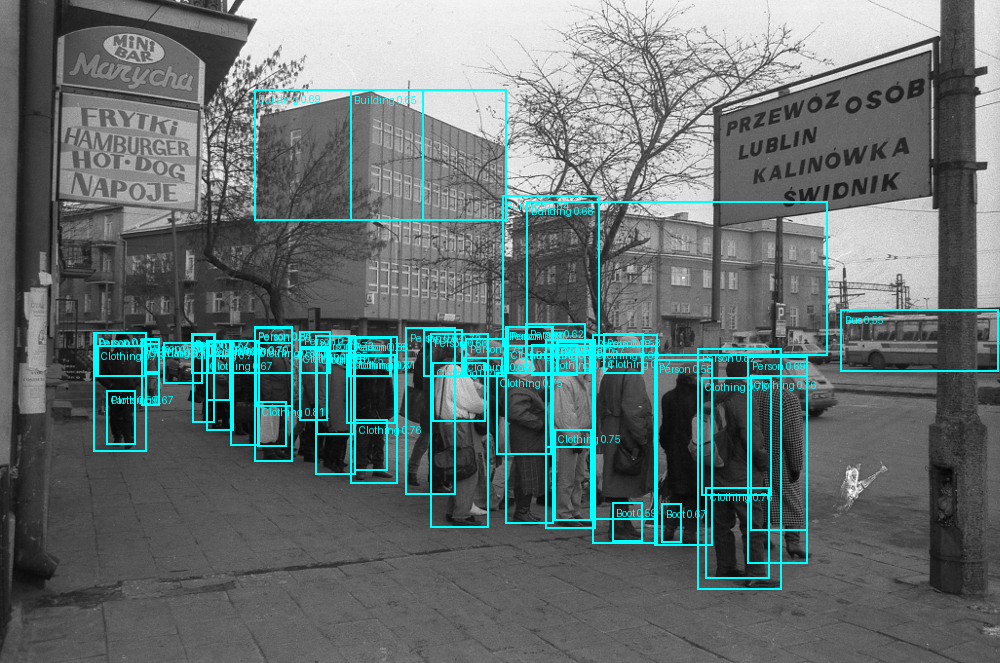

In [29]:
# --- Prosty NMS i rysunek ---
from PIL import ImageDraw

IOU_THR = 0.45

def iou(a, b):
    ax1, ay1, ax2, ay2 = a; bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1,bx1), max(ay1,by1)
    ix2, iy2 = min(ax2,bx2), min(ay2,by2)
    iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
    inter = iw*ih
    ua = (ax2-ax1)*(ay2-ay1) + (bx2-bx1)*(by2-by1) - inter
    return inter/max(ua,1e-6)

def nms(objs, iou_thr=IOU_THR):
    keep = []
    objs = sorted(objs, key=lambda d: d["score"], reverse=True)
    while objs:
        best = objs.pop(0)
        keep.append(best)
        objs = [o for o in objs if iou(best["bbox"], o["bbox"]) < iou_thr or o["name"]!=best["name"]]
    return keep

final = nms(raw_objs, IOU_THR)
print(f"Po NMS: {len(final)}")

viz = img0.copy()
draw = ImageDraw.Draw(viz)
for o in final:
    x1,y1,x2,y2 = o["bbox"]
    draw.rectangle([x1,y1,x2,y2], outline="cyan", width=2)
    draw.text((x1+4, y1+4), f"{o['name']} {o['score']:.2f}", fill="cyan")
display(viz)

Logo detections: 0

Top logo:


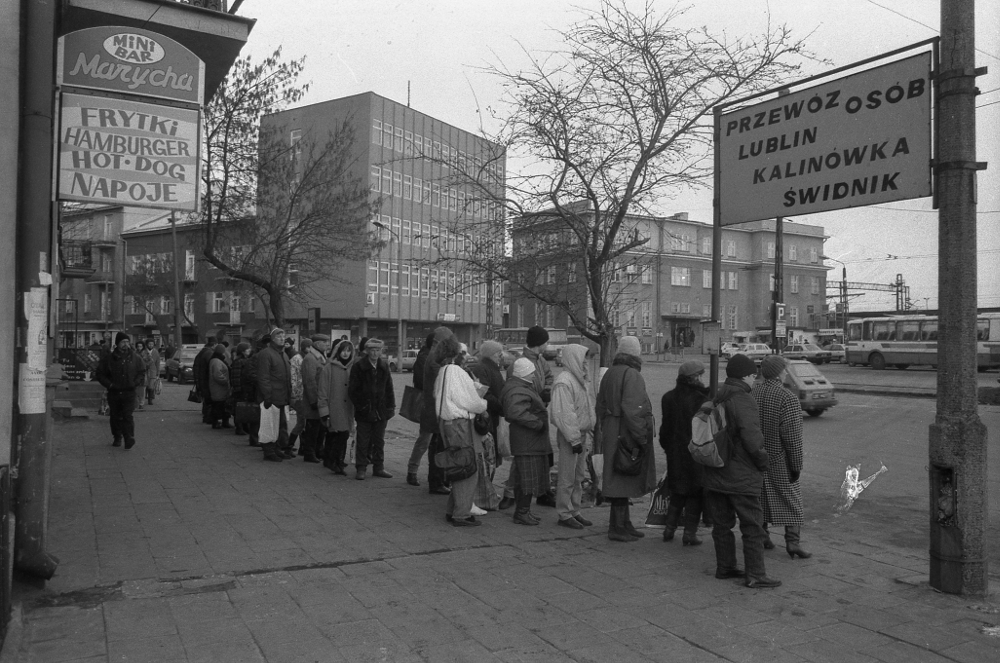

In [30]:
# 1) Wyodrębnij
logos = [o for o in raw_objs if o.get("src")=="logo" or str(o["name"]).startswith("LOGO:")]
print(f"Logo detections: {len(logos)}")
for o in sorted(logos, key=lambda x: -x["score"])[:20]:
    print(f"- {o['name']:30s}  {o['score']:.2f}  tile={o['tile']}  bbox={tuple(map(int,o['bbox']))}")

# 2) Podsumowanie trafień
from collections import Counter
cnt = Counter(o["name"] for o in logos)
print("\nTop logo:")
for k,v in cnt.most_common(10):
    ms = sum(o["score"] for o in logos if o["name"]==k)/v
    print(f"  {k:30s}  n={v:3d}  mean_score={ms:.2f}")

# 3) Wizualizacja (bbox = cały kafelek, więc półprzezroczysty overlay)
from PIL import ImageDraw
img_v = Image.open(IMG_PATH).convert("RGB")
draw = ImageDraw.Draw(img_v, "RGBA")
for o in logos:
    x1,y1,x2,y2 = map(int,o["bbox"])
    draw.rectangle([x1,y1,x2,y2], outline=(0,200,255,255), width=3)
    draw.rectangle([x1,y1,x1+180,y1+24], fill=(0,200,255,150))
    draw.text((x1+4,y1+4), f"{o['name']} {o['score']:.2f}", fill=(0,0,0,255))
display(img_v)

### 7) (Opcjonalnie) Porównanie z OCR — wczytaj wynik JSON i narysuj razem

OCR linie: 12


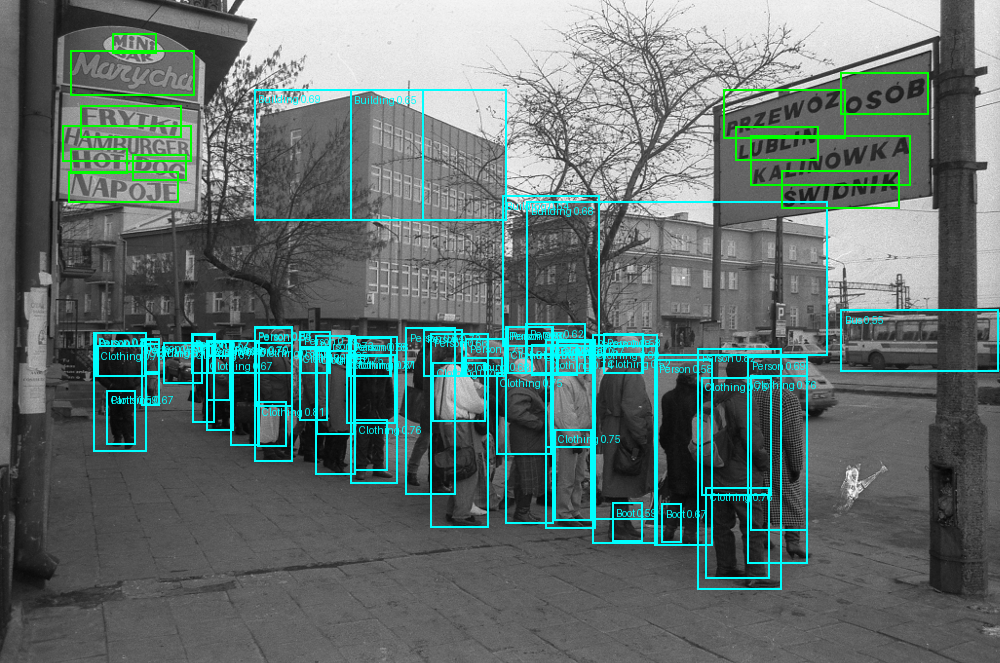


📜 Wszystkie teksty OCR (12):

001. MINI
002. Marycha
003. FRYTKI
004. HAMBURGER
005. HOT
006. DOG
007. NAPOJE
008. PRZEWOZ
009. OSOB
010. LUBLIN
011. KALINÓWKA
012. ŚWIDNIK


In [35]:
# Jeśli wcześniej zapisałaś linie OCR jako JSON (np. z 01_ocr.ipynb),
# tu można nałożyć obiekty + boxy tekstowe.
import json

OCR_JSON = (Path.home() / "MetaLogic" / "outputs" / "ocr" / f"{IMG_PATH.stem}_full.json")
if OCR_JSON.exists():
    lines = json.loads(OCR_JSON.read_text())
    print("OCR linie:", len(lines))
    viz2 = viz.copy(); d2 = ImageDraw.Draw(viz2)
    for l in lines:
        x1,y1,x2,y2 = l["bbox"]
        d2.rectangle([x1,y1,x2,y2], outline="lime", width=2)
    display(viz2)
else:
    print("Brak pliku:", OCR_JSON)

# wypisz teksty wykryte przez OCR
if OCR_JSON.exists():
    print(f"\n📜 Wszystkie teksty OCR ({len(lines)}):\n")
    for i, l in enumerate(lines, 1):
        print(f"{i:03d}. {l['text']}")


In [36]:
# === Pełna lista wszystkich wykrytych obiektów (Vision + Logo) ===
from pprint import pprint
from collections import Counter

# połącz obiekty i loga, jeśli masz osobno
all_objs = raw_objs  # lub: final + logos, zależnie od tego co masz

print(f"🔎 Wykryto łącznie: {len(all_objs)} obiektów\n")
for i, o in enumerate(sorted(all_objs, key=lambda x: -x["score"]), 1):
    name = o.get("name", "?")
    sc = o.get("score", 0)
    bbox = tuple(round(v, 1) for v in o.get("bbox", []))
    src = o.get("src", "vision")
    tile = o.get("tile", "-")
    print(f"{i:03d}. {name:30s}  score={sc:4.2f}  tile={tile:>3}  src={src:6s}  bbox={bbox}")

# jeśli chcesz w jednym obiekcie json (dla eksportu)
from pathlib import Path, PurePath
out_all = OUT_DIR / f"{PurePath(IMG_PATH).stem}_objects_full.json"
Path(out_all).write_text(json.dumps(all_objs, ensure_ascii=False, indent=2))
print(f"\n📁 Zapisano pełny wynik do: {out_all}")

counts = Counter([o["name"] for o in all_objs])
print(f"\n📊 Wszystkie klasy obiektów ({len(counts)}):")
for name, n in sorted(counts.items(), key=lambda x: -x[1]):
    print(f"• {name:30s} → {n}")

🔎 Wykryto łącznie: 155 obiektów

001. Person                          score=0.86  tile= 10  src=vision  bbox=(254.3, 326.2, 292.8, 461.2)
002. Person                          score=0.86  tile= 11  src=vision  bbox=(350.9, 336.6, 397.1, 483.2)
003. Clothing                        score=0.85  tile=  6  src=vision  bbox=(300.6, 346.0, 329.0, 373.6)
004. Person                          score=0.85  tile= 10  src=vision  bbox=(254.6, 326.4, 294.1, 459.0)
005. Clothing                        score=0.85  tile=  6  src=vision  bbox=(300.0, 345.8, 328.3, 376.0)
006. Person                          score=0.84  tile= 10  src=vision  bbox=(346.5, 336.8, 395.4, 481.9)
007. Person                          score=0.82  tile= 12  src=vision  bbox=(697.8, 348.2, 781.2, 589.5)
008. Person                          score=0.82  tile= 12  src=vision  bbox=(696.6, 347.7, 781.1, 586.9)
009. Person                          score=0.82  tile= 10  src=vision  bbox=(345.9, 339.9, 395.7, 477.7)
010. Clothing         

📸 Wizualizacja: 155 ramek


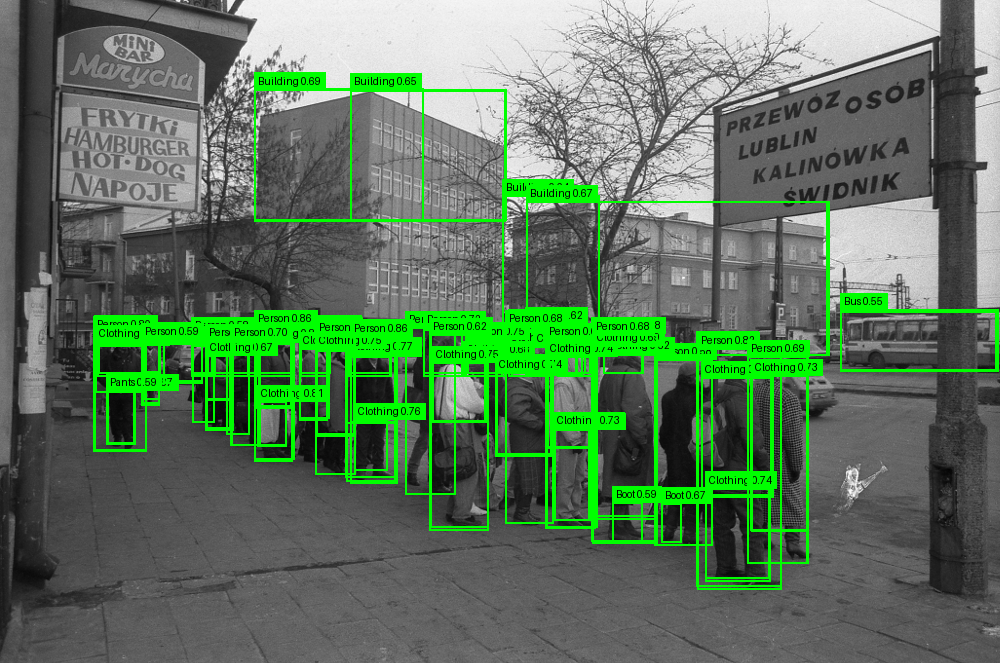

💾 Zapisano wizualizację do pliku:
/Users/olga/MetaLogic/outputs/objects/0077_objects_vis.jpg


In [37]:
# === Wizualizacja wykrytych obiektów (Vision + Logo) ===
from PIL import Image, ImageDraw, ImageFont

# jeśli masz all_objs z poprzedniej komórki:
img_vis = Image.open(IMG_PATH).convert("RGB")
draw = ImageDraw.Draw(img_vis)

try:
    font = ImageFont.truetype("DejaVuSans.ttf", 18)
except:
    font = ImageFont.load_default()

for o in all_objs:
    x1, y1, x2, y2 = map(int, o["bbox"])
    name = o.get("name", "?")
    score = o.get("score", 0)
    src = o.get("src", "vision")
    color = (0,255,255) if src=="logo" else (0,255,0)
    draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
    label = f"{name} {score:.2f}"
    tw, th = draw.textlength(label, font=font), font.size
    draw.rectangle([x1, y1-th-6, x1+tw+8, y1], fill=color)
    draw.text((x1+4, y1-th-4), label, fill="black", font=font)

print(f"📸 Wizualizacja: {len(all_objs)} ramek")
display(img_vis)

# zapis obrazu z ramkami
out_img = OUT_DIR / f"{IMG_PATH.stem}_objects_vis.jpg"
img_vis.save(out_img, quality=95)
print(f"💾 Zapisano wizualizację do pliku:\n{out_img}")

### 8) Eksport wyników do JSON/CSV

### 9) TODO / notatki
- [ ] Dodać baseline OpenCV DNN (MobileNet-SSD lub NanoDet) — mały model do testów.
- [ ] Wariant Ultralytics (YOLO) — tylko gdy będzie potrzebny i gdy mamy GPU/zgodność środowiska.
- [ ] Prosta metryka porównawcza: czas, liczba obiektów, IoU z ręcznymi anotacjami (jeśli powstaną).
- [ ] Batch: przetwarzanie całego katalogu i zapis do OUT_DIR.
